<a href="https://colab.research.google.com/github/sedaoturak/tricks_for_efficient_pytorch/blob/main/efficient_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Useful tips for more efficient Pytorch codes**

This list of tips was prepared by using the resources below:
1. https://nvlabs.github.io/eccv2020-mixed-precision-tutorial/files/szymon_migacz-pytorch-performance-tuning-guide.pdf
2. https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html 
3. https://efficientdl.com/faster-deep-learning-in-pytorch-a-guide/
4. https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b

An example model to show the tips (VAE with CNN)

*Model was taken from the website given below:*

https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

In [1]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('../outputs/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"../outputs/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../outputs/loss.jpg')
    plt.show()

In [2]:
from tqdm import tqdm
import torch 
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
    val_loss = running_loss / counter
    return val_loss

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

In [4]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.002
epochs = 100
batch_size = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

In [ ]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

# 1.DataLoader Attributes

1.1. set `num_workers > 0`

Rule of thumb: it is two times number of available GPU, otherwise it leads it to slow down!

`num_worker = 4 * num_GPU`

1.2. set `pin_memory=True`

It must be `True` together with `num_workers > 0`, otherwise it won't affect the speed.

recommended resource: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

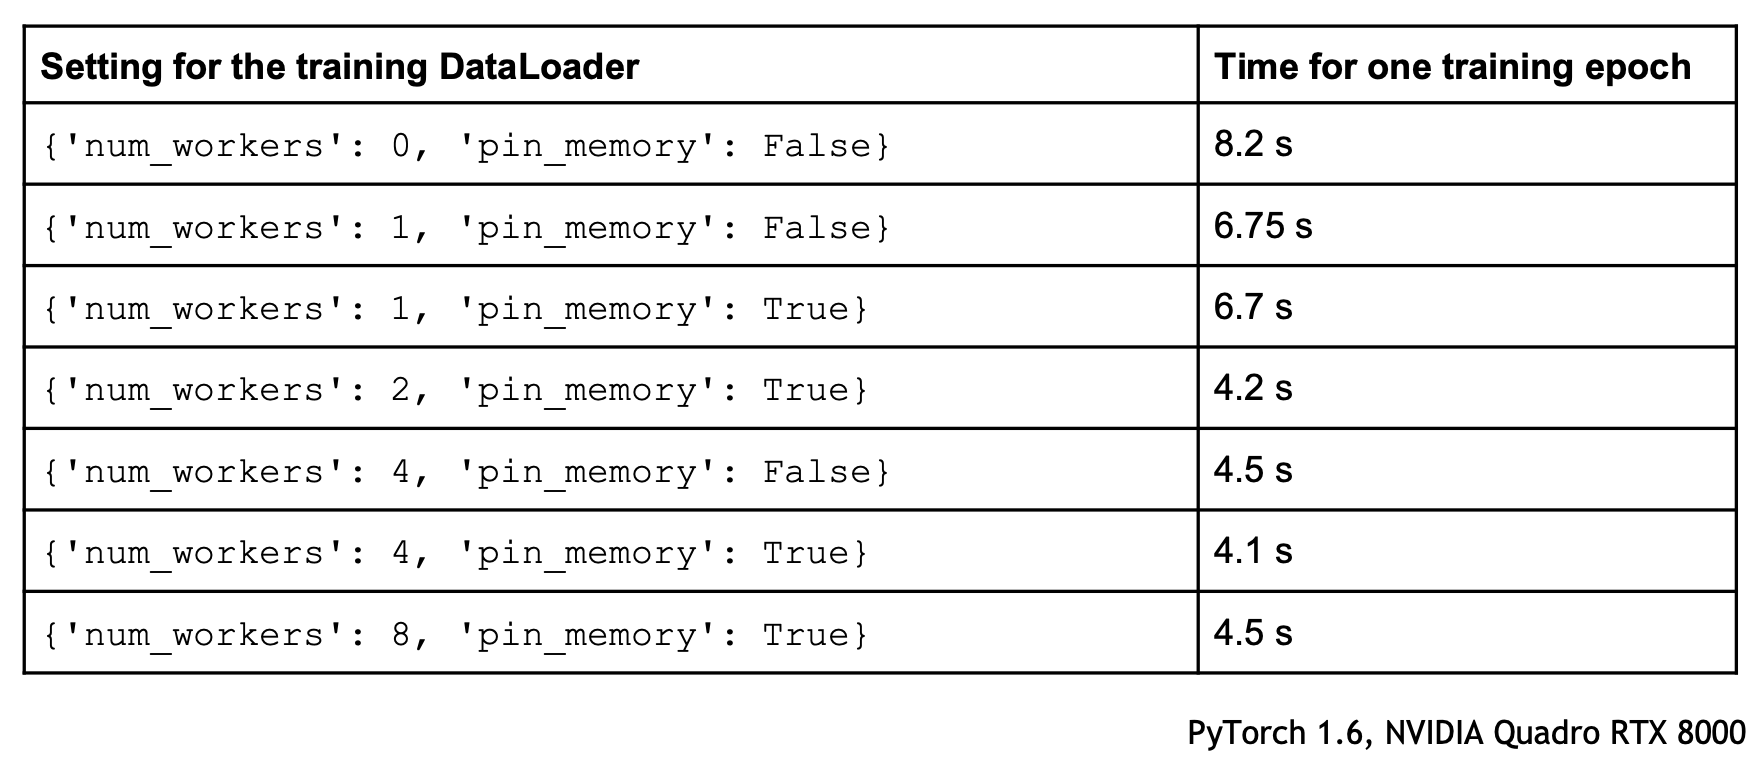

# 2.Balance Learning Rate and Batch Size

Double the learning rate when you double the batch size.

In [7]:
import time
start_time = time.time()

lr = 0.001
batch_size = 64

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch 1 of 100


938it [00:21, 43.86it/s]                         
157it [00:01, 97.90it/s]                         


Train Loss: 15736.3915
Val Loss: 12137.2865
Epoch 2 of 100


938it [00:15, 61.86it/s]
157it [00:01, 97.60it/s]                         


Train Loss: 11473.2856
Val Loss: 11074.1469
Epoch 3 of 100


938it [00:15, 60.34it/s]                         
157it [00:01, 97.33it/s]                         


Train Loss: 10811.8939
Val Loss: 10474.2668
Epoch 4 of 100


938it [00:14, 62.98it/s]                         
157it [00:01, 96.73it/s]                         


Train Loss: 10485.3948
Val Loss: 10354.4504
Epoch 5 of 100


938it [00:15, 60.30it/s]
157it [00:01, 99.08it/s]                          


Train Loss: 10362.3855
Val Loss: 10211.4170
Epoch 6 of 100


938it [00:14, 63.06it/s]                         
157it [00:01, 93.94it/s]                         


Train Loss: 10289.4507
Val Loss: 10163.3461
Epoch 7 of 100


938it [00:15, 59.04it/s]
157it [00:01, 95.89it/s]                         


Train Loss: 10231.7564
Val Loss: 10168.3119
Epoch 8 of 100


938it [00:16, 55.79it/s]                         
157it [00:01, 96.45it/s]                         


Train Loss: 10189.7020
Val Loss: 10133.2991
Epoch 9 of 100


938it [00:15, 60.68it/s]                         
157it [00:01, 83.63it/s]                         


Train Loss: 10153.4505
Val Loss: 10069.6244
Epoch 10 of 100


938it [00:15, 62.50it/s]                         
157it [00:01, 96.76it/s]                         


Train Loss: 10116.3014
Val Loss: 10054.5824
Epoch 11 of 100


938it [00:14, 62.59it/s]                         
157it [00:01, 96.06it/s]                         


Train Loss: 10024.5085
Val Loss: 9914.4110
Epoch 12 of 100


938it [00:15, 59.80it/s]                         
157it [00:01, 96.66it/s]                         


Train Loss: 9951.5011
Val Loss: 9878.7202
Epoch 13 of 100


938it [00:14, 62.90it/s]                         
157it [00:01, 95.48it/s]                         


Train Loss: 9911.5238
Val Loss: 9851.8873
Epoch 14 of 100


938it [00:15, 60.07it/s]                         
157it [00:01, 96.14it/s]                         


Train Loss: 9888.1015
Val Loss: 9828.7484
Epoch 15 of 100


938it [00:14, 63.09it/s]                         
157it [00:01, 96.92it/s]                         


Train Loss: 9867.1222
Val Loss: 9814.4015
Epoch 16 of 100


938it [00:15, 60.19it/s]
157it [00:01, 98.71it/s]                         


Train Loss: 9844.3417
Val Loss: 9815.5398
Epoch 17 of 100


938it [00:14, 63.16it/s]                         
157it [00:01, 98.48it/s]                         


Train Loss: 9834.2808
Val Loss: 9799.4648
Epoch 18 of 100


938it [00:15, 62.38it/s]                         
157it [00:02, 70.65it/s]                         


Train Loss: 9818.5048
Val Loss: 9848.5401
Epoch 19 of 100


938it [00:14, 63.44it/s]                         
157it [00:01, 96.50it/s]                         


Train Loss: 9801.9618
Val Loss: 9754.0937
Epoch 20 of 100


938it [00:14, 63.14it/s]                         
157it [00:01, 96.24it/s]                         


Train Loss: 9792.5443
Val Loss: 9738.2581
Epoch 21 of 100


938it [00:17, 54.76it/s]                         
157it [00:01, 97.47it/s]                         


Train Loss: 9777.0908
Val Loss: 9737.9170
Epoch 22 of 100


938it [00:14, 63.19it/s]
157it [00:01, 97.34it/s]                         


Train Loss: 9766.6120
Val Loss: 9716.3913
Epoch 23 of 100


938it [00:15, 60.07it/s]                         
157it [00:01, 97.96it/s] 


Train Loss: 9760.7452
Val Loss: 9692.5307
Epoch 24 of 100


938it [00:14, 63.31it/s]
157it [00:01, 98.21it/s]                         


Train Loss: 9748.5034
Val Loss: 9739.5230
Epoch 25 of 100


938it [00:15, 60.25it/s]                         
157it [00:01, 97.47it/s]                         


Train Loss: 9739.0081
Val Loss: 9690.5764
Epoch 26 of 100


938it [00:14, 63.44it/s]
157it [00:01, 97.55it/s]                         


Train Loss: 9731.5756
Val Loss: 9710.2220
Epoch 27 of 100


938it [00:15, 61.23it/s]                         
157it [00:01, 83.37it/s]                         


Train Loss: 9725.0214
Val Loss: 9699.6146
Epoch 28 of 100


938it [00:14, 63.36it/s]
157it [00:01, 95.99it/s]                         


Train Loss: 9717.9287
Val Loss: 9713.2899
Epoch 29 of 100


938it [00:14, 63.26it/s]
157it [00:01, 95.55it/s]                         


Train Loss: 9713.0721
Val Loss: 9716.7364
Epoch 30 of 100


938it [00:15, 60.50it/s]                         
157it [00:01, 97.01it/s]                         


Train Loss: 9704.0334
Val Loss: 9696.6939
Epoch 31 of 100


938it [00:14, 63.40it/s]                         
157it [00:01, 96.41it/s]                         


Train Loss: 9698.9785
Val Loss: 9700.2942
Epoch 32 of 100


938it [00:15, 60.76it/s]                         
157it [00:01, 97.06it/s]                         


Train Loss: 9694.9558
Val Loss: 9668.8640
Epoch 33 of 100


938it [00:16, 56.44it/s]                         
157it [00:01, 97.72it/s]                         


Train Loss: 9689.5250
Val Loss: 9679.9495
Epoch 34 of 100


938it [00:15, 60.40it/s]
157it [00:01, 97.90it/s]                         


Train Loss: 9681.0010
Val Loss: 9640.9865
Epoch 35 of 100


938it [00:14, 63.61it/s]
157it [00:01, 100.99it/s]                         


Train Loss: 9676.3941
Val Loss: 9644.1670
Epoch 36 of 100


938it [00:14, 63.53it/s]                         
157it [00:02, 72.24it/s]                         


Train Loss: 9672.8678
Val Loss: 9648.5365
Epoch 37 of 100


938it [00:15, 62.45it/s]                         
157it [00:01, 97.18it/s]                         


Train Loss: 9667.4459
Val Loss: 9685.5163
Epoch 38 of 100


938it [00:14, 63.58it/s]
157it [00:01, 97.48it/s]                         


Train Loss: 9663.0477
Val Loss: 9648.9279
Epoch 39 of 100


938it [00:15, 60.14it/s]                         
157it [00:01, 96.55it/s]                         


Train Loss: 9659.7687
Val Loss: 9639.9745
Epoch 40 of 100


938it [00:14, 63.54it/s]
157it [00:01, 98.74it/s]                         


Train Loss: 9656.5616
Val Loss: 9661.6535
Epoch 41 of 100


938it [00:15, 60.92it/s]                         
157it [00:01, 97.39it/s]                         


Train Loss: 9650.0394
Val Loss: 9667.8460
Epoch 42 of 100


938it [00:14, 63.81it/s]
157it [00:01, 98.41it/s]


Train Loss: 9649.0561
Val Loss: 9675.4286
Epoch 43 of 100


938it [00:15, 60.71it/s]                         
157it [00:01, 97.31it/s]                         


Train Loss: 9643.2710
Val Loss: 9664.3984
Epoch 44 of 100


938it [00:14, 63.79it/s]                         
157it [00:01, 96.51it/s]                         


Train Loss: 9642.6425
Val Loss: 9666.2479
Epoch 45 of 100


938it [00:14, 64.07it/s]
157it [00:01, 96.06it/s]                         


Train Loss: 9638.3886
Val Loss: 9617.6336
Epoch 46 of 100


938it [00:17, 55.01it/s]                         
157it [00:01, 97.02it/s]                         


Train Loss: 9635.6849
Val Loss: 9624.5963
Epoch 47 of 100


938it [00:14, 63.50it/s]                         
157it [00:01, 97.89it/s]                         


Train Loss: 9633.0265
Val Loss: 9659.3954
Epoch 48 of 100


938it [00:15, 60.47it/s]                         
157it [00:01, 98.60it/s]                          


Train Loss: 9628.5018
Val Loss: 9608.7944
Epoch 49 of 100


938it [00:14, 63.71it/s]
157it [00:01, 98.68it/s]                         


Train Loss: 9627.6409
Val Loss: 9671.2633
Epoch 50 of 100


938it [00:15, 60.83it/s]
157it [00:01, 97.59it/s]                         


Train Loss: 9624.8109
Val Loss: 9602.2755
Epoch 51 of 100


938it [00:14, 64.09it/s]
157it [00:01, 98.61it/s]                         


Train Loss: 9620.3061
Val Loss: 9639.9186
Epoch 52 of 100


938it [00:15, 60.93it/s]                         
157it [00:01, 97.31it/s]                         


Train Loss: 9616.0081
Val Loss: 9617.9574
Epoch 53 of 100


938it [00:14, 63.71it/s]
157it [00:01, 97.95it/s]                         


Train Loss: 9614.4764
Val Loss: 9618.6463
Epoch 54 of 100


938it [00:14, 63.86it/s]
157it [00:01, 96.69it/s]                         


Train Loss: 9614.1861
Val Loss: 9640.8504
Epoch 55 of 100


938it [00:15, 61.00it/s]                         
157it [00:01, 99.65it/s]                         


Train Loss: 9612.5407
Val Loss: 9607.9420
Epoch 56 of 100


938it [00:14, 63.70it/s]                         
157it [00:01, 97.65it/s]                         


Train Loss: 9608.4119
Val Loss: 9586.9162
Epoch 57 of 100


938it [00:15, 60.66it/s]                         
157it [00:01, 98.58it/s]                         


Train Loss: 9604.8068
Val Loss: 9602.8365
Epoch 58 of 100


938it [00:16, 56.43it/s]                         
157it [00:01, 96.93it/s]                         


Train Loss: 9604.0064
Val Loss: 9610.2911
Epoch 59 of 100


938it [00:15, 60.56it/s]                         
157it [00:01, 98.48it/s]                         


Train Loss: 9598.3904
Val Loss: 9608.8760
Epoch 60 of 100


938it [00:14, 63.81it/s]                         
157it [00:01, 96.07it/s]                         


Train Loss: 9600.0545
Val Loss: 9597.8800
Epoch 61 of 100


938it [00:14, 62.56it/s]                         
157it [00:02, 74.96it/s]                         


Train Loss: 9595.4274
Val Loss: 9592.4332
Epoch 62 of 100


938it [00:14, 64.30it/s]
157it [00:01, 98.01it/s]                         


Train Loss: 9595.3827
Val Loss: 9592.9979
Epoch 63 of 100


938it [00:14, 63.69it/s]
157it [00:01, 97.21it/s]                         


Train Loss: 9592.1300
Val Loss: 9603.2405
Epoch 64 of 100


938it [00:15, 61.04it/s]
157it [00:01, 97.16it/s]                         


Train Loss: 9593.4683
Val Loss: 9597.6321
Epoch 65 of 100


938it [00:14, 63.97it/s]
157it [00:01, 97.21it/s]                         


Train Loss: 9586.6213
Val Loss: 9598.8432
Epoch 66 of 100


938it [00:15, 60.54it/s]                         
157it [00:01, 99.71it/s]                         


Train Loss: 9586.5746
Val Loss: 9612.6485
Epoch 67 of 100


938it [00:14, 63.43it/s]
157it [00:01, 98.71it/s]                         


Train Loss: 9586.8942
Val Loss: 9603.1324
Epoch 68 of 100


938it [00:15, 61.04it/s]                         
157it [00:01, 97.59it/s]                         


Train Loss: 9581.6329
Val Loss: 9573.6433
Epoch 69 of 100


938it [00:14, 64.09it/s]                         
157it [00:01, 98.64it/s]                         


Train Loss: 9578.9383
Val Loss: 9633.0537
Epoch 70 of 100


938it [00:14, 63.98it/s]                         
157it [00:02, 71.64it/s]                         


Train Loss: 9579.0328
Val Loss: 9600.3889
Epoch 71 of 100


938it [00:16, 56.68it/s]
157it [00:01, 94.24it/s]                         


Train Loss: 9577.0105
Val Loss: 9596.3020
Epoch 72 of 100


938it [00:14, 64.05it/s]
157it [00:01, 98.79it/s]                         


Train Loss: 9575.5200
Val Loss: 9589.8577
Epoch 73 of 100


938it [00:15, 61.23it/s]                         
157it [00:01, 97.11it/s]                         


Train Loss: 9574.8971
Val Loss: 9586.8671
Epoch 74 of 100


938it [00:14, 63.86it/s]
157it [00:01, 98.13it/s]                         


Train Loss: 9572.6823
Val Loss: 9622.4670
Epoch 75 of 100


938it [00:15, 61.04it/s]
157it [00:01, 98.95it/s]                         


Train Loss: 9572.4891
Val Loss: 9573.6563
Epoch 76 of 100


938it [00:14, 63.57it/s]
157it [00:01, 98.30it/s]                         


Train Loss: 9565.6699
Val Loss: 9574.1462
Epoch 77 of 100


938it [00:15, 60.80it/s]                         
157it [00:01, 96.24it/s]                         


Train Loss: 9566.3696
Val Loss: 9560.9101
Epoch 78 of 100


938it [00:14, 62.76it/s]
157it [00:01, 96.24it/s]                         


Train Loss: 9567.3153
Val Loss: 9575.2215
Epoch 79 of 100


938it [00:15, 62.40it/s]
157it [00:01, 95.49it/s]                         


Train Loss: 9565.0600
Val Loss: 9601.3575
Epoch 80 of 100


938it [00:15, 59.32it/s]                         
157it [00:01, 94.48it/s]                         


Train Loss: 9565.2445
Val Loss: 9592.7340
Epoch 81 of 100


938it [00:15, 62.50it/s]
157it [00:01, 95.59it/s]                         


Train Loss: 9559.6222
Val Loss: 9569.9101
Epoch 82 of 100


938it [00:15, 60.18it/s]                         
157it [00:01, 97.65it/s]                         


Train Loss: 9562.9211
Val Loss: 9577.6132
Epoch 83 of 100


938it [00:14, 62.70it/s]
157it [00:01, 95.53it/s]                         


Train Loss: 9558.4138
Val Loss: 9556.1958
Epoch 84 of 100


938it [00:17, 54.41it/s]                         
157it [00:01, 96.39it/s]                         


Train Loss: 9558.4629
Val Loss: 9585.2922
Epoch 85 of 100


938it [00:14, 63.78it/s]
157it [00:01, 99.19it/s]                         


Train Loss: 9553.5627
Val Loss: 9581.1611
Epoch 86 of 100


938it [00:15, 60.49it/s]                         
157it [00:01, 97.72it/s]                         


Train Loss: 9556.1239
Val Loss: 9572.2622
Epoch 87 of 100


938it [00:14, 63.29it/s]                         
157it [00:01, 97.78it/s]                         


Train Loss: 9554.5700
Val Loss: 9599.5976
Epoch 88 of 100


938it [00:14, 62.92it/s]                         
157it [00:02, 71.02it/s]                         


Train Loss: 9548.0722
Val Loss: 9566.1095
Epoch 89 of 100


938it [00:14, 63.01it/s]                         
157it [00:01, 98.97it/s]                         


Train Loss: 9549.9061
Val Loss: 9570.7033
Epoch 90 of 100


938it [00:14, 63.26it/s]                         
157it [00:01, 98.20it/s]                         


Train Loss: 9549.9153
Val Loss: 9571.3019
Epoch 91 of 100


938it [00:15, 60.48it/s]                         
157it [00:01, 96.27it/s]                         


Train Loss: 9546.1497
Val Loss: 9547.0320
Epoch 92 of 100


938it [00:14, 63.94it/s]
157it [00:01, 98.05it/s]                         


Train Loss: 9546.6362
Val Loss: 9567.8399
Epoch 93 of 100


938it [00:15, 60.74it/s]                         
157it [00:01, 97.64it/s]                         


Train Loss: 9546.9055
Val Loss: 9574.4108
Epoch 94 of 100


938it [00:14, 63.61it/s]
157it [00:01, 96.81it/s]                         


Train Loss: 9542.5646
Val Loss: 9558.7976
Epoch 95 of 100


938it [00:15, 60.51it/s]                         
157it [00:01, 96.37it/s]                         


Train Loss: 9543.6513
Val Loss: 9543.7586
Epoch 96 of 100


938it [00:16, 56.14it/s]                         
157it [00:01, 97.40it/s]                         


Train Loss: 9544.5307
Val Loss: 9563.7493
Epoch 97 of 100


938it [00:14, 63.58it/s]
157it [00:02, 77.52it/s]                         


Train Loss: 9542.3376
Val Loss: 9550.1833
Epoch 98 of 100


938it [00:15, 62.11it/s]                         
157it [00:01, 96.26it/s]                         


Train Loss: 9541.0818
Val Loss: 9561.6578
Epoch 99 of 100


938it [00:14, 64.00it/s]
157it [00:01, 99.00it/s]                         


Train Loss: 9540.3129
Val Loss: 9558.2521
Epoch 100 of 100


938it [00:15, 60.58it/s]                         
157it [00:01, 97.30it/s]                         

Train Loss: 9538.7081
Val Loss: 9561.1383
Total time: 1695.400s


In [13]:
import time
start_time = time.time()

lr = 0.002
batch_size = 128

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch 1 of 100


469it [00:12, 36.61it/s]                         
79it [00:01, 53.96it/s]                        


Train Loss: 35841.1689
Val Loss: 29091.4053
Epoch 2 of 100


469it [00:12, 38.71it/s]                         
79it [00:01, 54.04it/s]                        


Train Loss: 25743.0575
Val Loss: 23160.1966
Epoch 3 of 100


469it [00:12, 38.98it/s]                         
79it [00:01, 54.26it/s]                        


Train Loss: 22804.9781
Val Loss: 22091.6339
Epoch 4 of 100


469it [00:12, 36.27it/s]                         
79it [00:01, 53.18it/s]                        


Train Loss: 22247.8616
Val Loss: 21873.8327
Epoch 5 of 100


469it [00:12, 38.31it/s]
79it [00:01, 53.15it/s]                        


Train Loss: 21956.4236
Val Loss: 21629.2794
Epoch 6 of 100


469it [00:12, 38.51it/s]                         
79it [00:01, 53.57it/s]                        


Train Loss: 21778.4737
Val Loss: 21393.8246
Epoch 7 of 100


469it [00:12, 36.29it/s]                         
79it [00:01, 54.45it/s]                        


Train Loss: 21635.3604
Val Loss: 21296.5063
Epoch 8 of 100


469it [00:13, 34.38it/s]                         
79it [00:01, 54.32it/s]                        


Train Loss: 21532.4567
Val Loss: 21239.5256
Epoch 9 of 100


469it [00:12, 38.53it/s]                         
79it [00:02, 39.22it/s]                        


Train Loss: 21457.8101
Val Loss: 21277.8454
Epoch 10 of 100


469it [00:12, 37.81it/s]                         
79it [00:01, 53.42it/s]                        


Train Loss: 21369.8300
Val Loss: 21121.1753
Epoch 11 of 100


469it [00:12, 38.51it/s]                         
79it [00:01, 54.31it/s]                        


Train Loss: 21291.6648
Val Loss: 20972.1352
Epoch 12 of 100


469it [00:12, 38.65it/s]                         
79it [00:02, 37.00it/s]                        


Train Loss: 20976.7720
Val Loss: 20660.4877
Epoch 13 of 100


469it [00:12, 38.16it/s]                         
79it [00:01, 54.45it/s]                        


Train Loss: 20813.1513
Val Loss: 20602.1571
Epoch 14 of 100


469it [00:12, 38.66it/s]
79it [00:01, 53.28it/s]                        


Train Loss: 20722.2826
Val Loss: 20456.6200
Epoch 15 of 100


469it [00:12, 37.33it/s]                         
79it [00:01, 40.65it/s]                        


Train Loss: 20642.5389
Val Loss: 20446.9796
Epoch 16 of 100


469it [00:12, 38.58it/s]                         
79it [00:01, 54.06it/s]                        


Train Loss: 20588.5556
Val Loss: 20321.0113
Epoch 17 of 100


469it [00:12, 38.48it/s]
79it [00:01, 53.71it/s]                        


Train Loss: 20422.4354
Val Loss: 20104.5943
Epoch 18 of 100


469it [00:12, 37.45it/s]                         
79it [00:02, 38.16it/s]                        


Train Loss: 20214.5369
Val Loss: 19892.2580
Epoch 19 of 100


469it [00:12, 38.25it/s]                         
79it [00:01, 53.46it/s]                        


Train Loss: 20105.3388
Val Loss: 19872.5878
Epoch 20 of 100


469it [00:13, 35.44it/s]                         
79it [00:01, 39.95it/s]                        


Train Loss: 20053.0490
Val Loss: 19893.0216
Epoch 21 of 100


469it [00:12, 36.30it/s]
79it [00:01, 52.99it/s]                        


Train Loss: 20000.6571
Val Loss: 19761.2405
Epoch 22 of 100


469it [00:12, 38.17it/s]                         
79it [00:01, 53.24it/s]                        


Train Loss: 19952.6963
Val Loss: 19751.2101
Epoch 23 of 100


469it [00:12, 38.55it/s]
79it [00:01, 54.08it/s]                        


Train Loss: 19926.1527
Val Loss: 19732.4670
Epoch 24 of 100


469it [00:13, 36.06it/s]                         
79it [00:01, 53.63it/s]                        


Train Loss: 19896.2064
Val Loss: 19685.2509
Epoch 25 of 100


469it [00:12, 38.80it/s]
79it [00:01, 53.82it/s]                        


Train Loss: 19860.0010
Val Loss: 19674.9782
Epoch 26 of 100


469it [00:12, 38.65it/s]                         
79it [00:01, 54.21it/s]                        


Train Loss: 19828.8900
Val Loss: 19646.4035
Epoch 27 of 100


469it [00:12, 36.32it/s]                         
79it [00:01, 53.81it/s]                        


Train Loss: 19806.5153
Val Loss: 19608.6679
Epoch 28 of 100


469it [00:12, 38.40it/s]                         
79it [00:01, 54.47it/s]                        


Train Loss: 19788.0829
Val Loss: 19590.0587
Epoch 29 of 100


469it [00:11, 39.10it/s]                         
79it [00:01, 54.08it/s]                        


Train Loss: 19760.8923
Val Loss: 19577.9062
Epoch 30 of 100


469it [00:12, 37.09it/s]
79it [00:01, 48.11it/s]                        


Train Loss: 19732.2592
Val Loss: 19575.8912
Epoch 31 of 100


469it [00:12, 38.96it/s]                         
79it [00:01, 53.49it/s]                        


Train Loss: 19726.0429
Val Loss: 19573.0783
Epoch 32 of 100


469it [00:12, 36.67it/s]                         
79it [00:01, 54.74it/s]                        


Train Loss: 19707.3625
Val Loss: 19599.6493
Epoch 33 of 100


469it [00:13, 34.84it/s]
79it [00:01, 54.92it/s]                        


Train Loss: 19693.8770
Val Loss: 19508.1277
Epoch 34 of 100


469it [00:12, 38.80it/s]                         
79it [00:01, 54.16it/s]                        


Train Loss: 19679.7104
Val Loss: 19535.7827
Epoch 35 of 100


469it [00:11, 39.44it/s]
79it [00:01, 55.04it/s]                        


Train Loss: 19661.2945
Val Loss: 19523.6859
Epoch 36 of 100


469it [00:11, 39.19it/s]                         
79it [00:02, 38.03it/s]                        


Train Loss: 19657.3510
Val Loss: 19547.9231
Epoch 37 of 100


469it [00:12, 38.58it/s]
79it [00:01, 53.63it/s]                        


Train Loss: 19637.6137
Val Loss: 19461.5974
Epoch 38 of 100


469it [00:11, 39.33it/s]                         
79it [00:01, 54.98it/s]                        


Train Loss: 19628.5751
Val Loss: 19456.0048
Epoch 39 of 100


469it [00:12, 38.53it/s]
79it [00:01, 54.01it/s]                        


Train Loss: 19621.4350
Val Loss: 19545.8433
Epoch 40 of 100


469it [00:12, 36.52it/s]
79it [00:01, 53.90it/s]                        


Train Loss: 19611.0883
Val Loss: 19515.7313
Epoch 41 of 100


469it [00:12, 38.78it/s]                         
79it [00:01, 54.29it/s]                        


Train Loss: 19599.4798
Val Loss: 19491.1752
Epoch 42 of 100


469it [00:12, 38.76it/s]
79it [00:01, 53.84it/s]                        


Train Loss: 19597.5958
Val Loss: 19489.2373
Epoch 43 of 100


469it [00:12, 36.83it/s]
79it [00:01, 54.88it/s]                        


Train Loss: 19586.1933
Val Loss: 19432.0772
Epoch 44 of 100


469it [00:11, 39.11it/s]
79it [00:01, 54.21it/s]                        


Train Loss: 19569.1653
Val Loss: 19442.5974
Epoch 45 of 100


469it [00:13, 35.17it/s]                         
79it [00:01, 50.05it/s]                        


Train Loss: 19559.4812
Val Loss: 19430.1082
Epoch 46 of 100


469it [00:12, 36.78it/s]                         
79it [00:01, 55.42it/s]                        


Train Loss: 19544.1884
Val Loss: 19463.0454
Epoch 47 of 100


469it [00:11, 39.11it/s]                         
79it [00:01, 54.45it/s]                        


Train Loss: 19559.1361
Val Loss: 19476.3701
Epoch 48 of 100


469it [00:11, 39.20it/s]                         
79it [00:01, 54.64it/s]                        


Train Loss: 19542.3786
Val Loss: 19407.9743
Epoch 49 of 100


469it [00:12, 36.90it/s]                         
79it [00:01, 54.33it/s]                        


Train Loss: 19532.8662
Val Loss: 19454.4708
Epoch 50 of 100


469it [00:12, 38.90it/s]                         
79it [00:01, 53.58it/s]                        


Train Loss: 19522.2639
Val Loss: 19395.5540
Epoch 51 of 100


469it [00:12, 39.04it/s]                         
79it [00:01, 54.72it/s]                        


Train Loss: 19518.4292
Val Loss: 19398.0912
Epoch 52 of 100


469it [00:12, 36.77it/s]
79it [00:01, 54.33it/s]                        


Train Loss: 19517.7209
Val Loss: 19419.1993
Epoch 53 of 100


469it [00:12, 38.88it/s]                         
79it [00:01, 54.61it/s]                        


Train Loss: 19509.8003
Val Loss: 19406.4237
Epoch 54 of 100


469it [00:11, 39.12it/s]                         
79it [00:01, 55.27it/s]                        


Train Loss: 19507.4165
Val Loss: 19408.3605
Epoch 55 of 100


469it [00:12, 36.28it/s]                         
79it [00:01, 54.60it/s]                        


Train Loss: 19493.5279
Val Loss: 19490.4599
Epoch 56 of 100


469it [00:12, 38.85it/s]
79it [00:01, 54.34it/s]                        


Train Loss: 19493.1548
Val Loss: 19444.7198
Epoch 57 of 100


469it [00:12, 37.82it/s]                         
79it [00:01, 43.33it/s]                        


Train Loss: 19483.3098
Val Loss: 19335.2504
Epoch 58 of 100


469it [00:13, 33.91it/s]                         
79it [00:01, 54.38it/s]                        


Train Loss: 19471.2582
Val Loss: 19394.2699
Epoch 59 of 100


469it [00:12, 39.06it/s]                         
79it [00:01, 53.30it/s]                        


Train Loss: 19474.2847
Val Loss: 19380.7274
Epoch 60 of 100


469it [00:12, 38.61it/s]                         
79it [00:01, 54.83it/s]                        


Train Loss: 19467.1177
Val Loss: 19397.5138
Epoch 61 of 100


469it [00:12, 36.23it/s]
79it [00:01, 54.40it/s]                        


Train Loss: 19464.4947
Val Loss: 19383.9655
Epoch 62 of 100


469it [00:12, 38.57it/s]                         
79it [00:01, 54.65it/s]                        


Train Loss: 19455.0468
Val Loss: 19344.2695
Epoch 63 of 100


469it [00:12, 38.71it/s]                         
79it [00:01, 54.22it/s]                        


Train Loss: 19457.9911
Val Loss: 19323.0031
Epoch 64 of 100


469it [00:12, 36.77it/s]                         
79it [00:01, 54.42it/s]                        


Train Loss: 19452.0481
Val Loss: 19376.9677
Epoch 65 of 100


469it [00:12, 38.87it/s]
79it [00:01, 53.62it/s]                        


Train Loss: 19447.1223
Val Loss: 19345.5035
Epoch 66 of 100


469it [00:11, 39.13it/s]                         
79it [00:01, 54.89it/s]                        


Train Loss: 19440.8686
Val Loss: 19370.5231
Epoch 67 of 100


469it [00:12, 36.62it/s]                         
79it [00:01, 54.68it/s]                        


Train Loss: 19439.0248
Val Loss: 19346.5277
Epoch 68 of 100


469it [00:12, 38.64it/s]                         
79it [00:01, 55.11it/s]                        


Train Loss: 19431.9474
Val Loss: 19378.9752
Epoch 69 of 100


469it [00:12, 38.87it/s]                         
79it [00:01, 53.37it/s]                        


Train Loss: 19424.9266
Val Loss: 19376.2017
Epoch 70 of 100


469it [00:13, 34.61it/s]                         
79it [00:01, 54.21it/s]                        


Train Loss: 19429.3664
Val Loss: 19359.2140
Epoch 71 of 100


469it [00:12, 36.79it/s]                         
79it [00:01, 53.57it/s]                        


Train Loss: 19420.2224
Val Loss: 19375.3982
Epoch 72 of 100


469it [00:11, 39.10it/s]                         
79it [00:01, 54.33it/s]                        


Train Loss: 19413.5083
Val Loss: 19341.3671
Epoch 73 of 100


469it [00:12, 39.04it/s]                         
79it [00:02, 36.45it/s]                        


Train Loss: 19417.4012
Val Loss: 19325.0572
Epoch 74 of 100


469it [00:12, 38.89it/s]                         
79it [00:01, 55.37it/s]                        


Train Loss: 19413.6181
Val Loss: 19395.7274
Epoch 75 of 100


469it [00:11, 39.10it/s]                         
79it [00:01, 53.82it/s]                        


Train Loss: 19410.5571
Val Loss: 19321.6133
Epoch 76 of 100


469it [00:11, 39.26it/s]
79it [00:01, 49.32it/s]                        


Train Loss: 19409.5425
Val Loss: 19370.3437
Epoch 77 of 100


469it [00:12, 37.37it/s]
79it [00:01, 54.67it/s]                        


Train Loss: 19404.7956
Val Loss: 19320.3871
Epoch 78 of 100


469it [00:11, 39.28it/s]                         
79it [00:01, 54.20it/s]                        


Train Loss: 19401.4866
Val Loss: 19306.7801
Epoch 79 of 100


469it [00:11, 39.17it/s]                         
79it [00:01, 54.25it/s]                        


Train Loss: 19396.7417
Val Loss: 19340.1026
Epoch 80 of 100


469it [00:12, 36.75it/s]                         
79it [00:01, 53.79it/s]                        


Train Loss: 19390.7390
Val Loss: 19410.0881
Epoch 81 of 100


469it [00:12, 39.08it/s]                         
79it [00:01, 55.49it/s]                        


Train Loss: 19392.3240
Val Loss: 19322.0268
Epoch 82 of 100


469it [00:11, 39.22it/s]                         
79it [00:01, 54.01it/s]                        


Train Loss: 19389.3268
Val Loss: 19299.4255
Epoch 83 of 100


469it [00:12, 38.82it/s]                         
79it [00:01, 54.88it/s]                        


Train Loss: 19381.8490
Val Loss: 19323.1412
Epoch 84 of 100


469it [00:12, 38.96it/s]
79it [00:01, 53.25it/s]                        


Train Loss: 19380.9240
Val Loss: 19350.1216
Epoch 85 of 100


469it [00:12, 36.95it/s]
79it [00:01, 52.64it/s]                        


Train Loss: 19369.8912
Val Loss: 19300.5079
Epoch 86 of 100


469it [00:12, 36.61it/s]                         
79it [00:02, 39.03it/s]                        


Train Loss: 19376.1364
Val Loss: 19340.9285
Epoch 87 of 100


469it [00:12, 37.65it/s]                         
79it [00:01, 53.42it/s]                        


Train Loss: 19370.5008
Val Loss: 19322.9824
Epoch 88 of 100


469it [00:12, 36.47it/s]                         
79it [00:01, 53.87it/s]                        


Train Loss: 19372.3292
Val Loss: 19336.7089
Epoch 89 of 100


469it [00:11, 39.11it/s]                         
79it [00:01, 54.07it/s]                        


Train Loss: 19370.8300
Val Loss: 19307.0874
Epoch 90 of 100


469it [00:12, 38.97it/s]                         
79it [00:01, 54.31it/s]                        


Train Loss: 19362.4068
Val Loss: 19270.5263
Epoch 91 of 100


469it [00:12, 36.57it/s]
79it [00:01, 55.56it/s]                        


Train Loss: 19350.5932
Val Loss: 19252.1214
Epoch 92 of 100


469it [00:12, 38.45it/s]                         
79it [00:01, 54.02it/s]                        


Train Loss: 19375.2049
Val Loss: 19287.2660
Epoch 93 of 100


469it [00:12, 38.46it/s]                         
79it [00:01, 53.83it/s]                        


Train Loss: 19356.7663
Val Loss: 19302.1971
Epoch 94 of 100


469it [00:12, 36.28it/s]                         
79it [00:01, 53.57it/s]                        


Train Loss: 19355.8860
Val Loss: 19296.6803
Epoch 95 of 100


469it [00:12, 38.80it/s]                         
79it [00:01, 54.48it/s]                        


Train Loss: 19353.2202
Val Loss: 19259.8320
Epoch 96 of 100


469it [00:11, 39.28it/s]                         
79it [00:01, 54.06it/s]                        


Train Loss: 19345.8354
Val Loss: 19259.1848
Epoch 97 of 100


469it [00:12, 36.56it/s]
79it [00:01, 54.59it/s]                        


Train Loss: 19342.5568
Val Loss: 19333.7870
Epoch 98 of 100


469it [00:12, 38.75it/s]                         
79it [00:01, 52.63it/s]                        


Train Loss: 19349.2145
Val Loss: 19332.1876
Epoch 99 of 100


469it [00:12, 38.99it/s]
79it [00:01, 55.08it/s]                        


Train Loss: 19347.4693
Val Loss: 19290.4000
Epoch 100 of 100


469it [00:14, 32.95it/s]                         
79it [00:01, 54.49it/s]                        

Train Loss: 19338.7127
Val Loss: 19289.9023
Total time: 1393.210s


In [11]:
import time
start_time = time.time()

lr = 0.001
batch_size = 128

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch 1 of 100


469it [00:12, 36.51it/s]                         
79it [00:01, 54.91it/s]                        


Train Loss: 34868.7858
Val Loss: 25262.6178
Epoch 2 of 100


469it [00:12, 39.06it/s]                         
79it [00:01, 54.03it/s]                        


Train Loss: 24114.3682
Val Loss: 22973.7758
Epoch 3 of 100


469it [00:11, 39.19it/s]                         
79it [00:01, 54.13it/s]                        


Train Loss: 22681.0577
Val Loss: 21736.7458
Epoch 4 of 100


469it [00:13, 33.93it/s]                         
79it [00:01, 43.87it/s]                        


Train Loss: 21869.5530
Val Loss: 21364.3093
Epoch 5 of 100


469it [00:12, 39.05it/s]                         
79it [00:01, 53.61it/s]                        


Train Loss: 21571.3392
Val Loss: 21149.4506
Epoch 6 of 100


469it [00:12, 38.54it/s]                         
79it [00:02, 38.26it/s]                        


Train Loss: 21368.1332
Val Loss: 20961.2054
Epoch 7 of 100


469it [00:11, 39.19it/s]
79it [00:01, 55.08it/s]                        


Train Loss: 21074.4935
Val Loss: 20531.8732
Epoch 8 of 100


469it [00:11, 39.09it/s]                         
79it [00:01, 54.31it/s]                        


Train Loss: 20585.8444
Val Loss: 20138.7117
Epoch 9 of 100


469it [00:12, 38.89it/s]                         
79it [00:02, 38.23it/s]                        


Train Loss: 20275.4665
Val Loss: 19882.1759
Epoch 10 of 100


469it [00:11, 39.24it/s]
79it [00:01, 55.36it/s]                        


Train Loss: 20108.2367
Val Loss: 19784.5380
Epoch 11 of 100


469it [00:11, 39.24it/s]                         
79it [00:01, 56.22it/s]                        


Train Loss: 20003.2607
Val Loss: 19739.2067
Epoch 12 of 100


469it [00:11, 39.56it/s]
79it [00:02, 35.53it/s]                        


Train Loss: 19916.1726
Val Loss: 19605.1808
Epoch 13 of 100


469it [00:12, 38.94it/s]
79it [00:01, 54.32it/s]                        


Train Loss: 19854.6349
Val Loss: 19585.7980
Epoch 14 of 100


469it [00:12, 39.05it/s]                         
79it [00:01, 54.27it/s]                        


Train Loss: 19808.3080
Val Loss: 19562.9850
Epoch 15 of 100


469it [00:12, 38.24it/s]                         
79it [00:01, 39.99it/s]                        


Train Loss: 19751.6057
Val Loss: 19509.7099
Epoch 16 of 100


469it [00:12, 38.77it/s]                         
79it [00:01, 53.99it/s]                        


Train Loss: 19712.4355
Val Loss: 19532.1135
Epoch 17 of 100


469it [00:12, 39.00it/s]                         
79it [00:01, 54.11it/s]                        


Train Loss: 19678.3634
Val Loss: 19575.6730
Epoch 18 of 100


469it [00:12, 36.50it/s]                         
79it [00:01, 54.72it/s]                        


Train Loss: 19638.5582
Val Loss: 19384.2553
Epoch 19 of 100


469it [00:12, 38.93it/s]                         
79it [00:01, 53.59it/s]                        


Train Loss: 19606.3269
Val Loss: 19342.3717
Epoch 20 of 100


469it [00:13, 34.36it/s]
79it [00:01, 54.15it/s]                        


Train Loss: 19579.7974
Val Loss: 19399.6520
Epoch 21 of 100


469it [00:12, 36.42it/s]
79it [00:01, 53.92it/s]                        


Train Loss: 19549.7408
Val Loss: 19322.9278
Epoch 22 of 100


469it [00:12, 38.29it/s]                         
79it [00:01, 54.25it/s]                        


Train Loss: 19529.2076
Val Loss: 19330.6713
Epoch 23 of 100


469it [00:12, 38.51it/s]
79it [00:01, 53.32it/s]                        


Train Loss: 19501.8502
Val Loss: 19383.2184
Epoch 24 of 100


469it [00:13, 36.01it/s]
79it [00:01, 54.02it/s]                        


Train Loss: 19483.4647
Val Loss: 19285.4866
Epoch 25 of 100


469it [00:12, 38.40it/s]                         
79it [00:01, 54.23it/s]                        


Train Loss: 19467.1539
Val Loss: 19251.3082
Epoch 26 of 100


469it [00:12, 38.53it/s]
79it [00:01, 53.93it/s]                        


Train Loss: 19447.4437
Val Loss: 19275.5115
Epoch 27 of 100


469it [00:12, 36.12it/s]                         
79it [00:01, 53.14it/s]                        


Train Loss: 19429.0180
Val Loss: 19189.5457
Epoch 28 of 100


469it [00:12, 38.64it/s]                         
79it [00:01, 54.07it/s]                        


Train Loss: 19408.9071
Val Loss: 19251.0464
Epoch 29 of 100


469it [00:12, 38.58it/s]                         
79it [00:01, 53.20it/s]                        


Train Loss: 19397.5603
Val Loss: 19174.8158
Epoch 30 of 100


469it [00:12, 38.51it/s]
79it [00:01, 54.24it/s]                        


Train Loss: 19391.3394
Val Loss: 19215.5221
Epoch 31 of 100


469it [00:12, 38.72it/s]                         
79it [00:01, 53.84it/s]                        


Train Loss: 19368.4955
Val Loss: 19159.4216
Epoch 32 of 100


469it [00:12, 38.61it/s]                         
79it [00:01, 53.96it/s]                        


Train Loss: 19357.6930
Val Loss: 19143.7917
Epoch 33 of 100


469it [00:12, 37.12it/s]                         
79it [00:01, 43.02it/s]                        


Train Loss: 19348.0990
Val Loss: 19141.5569
Epoch 34 of 100


469it [00:12, 36.53it/s]                         
79it [00:01, 46.66it/s]                        


Train Loss: 19332.0670
Val Loss: 19181.1064
Epoch 35 of 100


469it [00:12, 36.90it/s]                         
79it [00:01, 53.91it/s]                        


Train Loss: 19318.7504
Val Loss: 19134.7881
Epoch 36 of 100


469it [00:12, 36.23it/s]                         
79it [00:01, 54.28it/s]                        


Train Loss: 19311.6705
Val Loss: 19126.8085
Epoch 37 of 100


469it [00:12, 38.69it/s]
79it [00:01, 53.28it/s]                        


Train Loss: 19296.1004
Val Loss: 19129.9441
Epoch 38 of 100


469it [00:12, 38.52it/s]                         
79it [00:01, 54.10it/s]                        


Train Loss: 19283.0454
Val Loss: 19129.1792
Epoch 39 of 100


469it [00:12, 36.14it/s]                         
79it [00:01, 53.61it/s]                        


Train Loss: 19283.8572
Val Loss: 19165.5770
Epoch 40 of 100


469it [00:12, 38.66it/s]                         
79it [00:01, 53.53it/s]                        


Train Loss: 19271.5864
Val Loss: 19129.7434
Epoch 41 of 100


469it [00:12, 38.72it/s]                         
79it [00:01, 53.59it/s]                        


Train Loss: 19261.9407
Val Loss: 19116.0366
Epoch 42 of 100


469it [00:12, 36.15it/s]                         
79it [00:01, 53.88it/s]                        


Train Loss: 19255.9254
Val Loss: 19107.1444
Epoch 43 of 100


469it [00:12, 38.63it/s]
79it [00:01, 52.36it/s]                        


Train Loss: 19245.4121
Val Loss: 19084.8667
Epoch 44 of 100


469it [00:12, 38.31it/s]                         
79it [00:01, 53.07it/s]                        


Train Loss: 19244.7953
Val Loss: 19074.3781
Epoch 45 of 100


469it [00:12, 36.23it/s]                         
79it [00:01, 53.59it/s]                        


Train Loss: 19232.1340
Val Loss: 19093.5556
Epoch 46 of 100


469it [00:12, 36.25it/s]                         
79it [00:01, 41.88it/s]                        


Train Loss: 19229.5935
Val Loss: 19096.7382
Epoch 47 of 100


469it [00:12, 37.21it/s]                         
79it [00:01, 53.39it/s]                        


Train Loss: 19215.1130
Val Loss: 19067.5754
Epoch 48 of 100


469it [00:12, 36.38it/s]                         
79it [00:01, 53.23it/s]                        


Train Loss: 19209.1270
Val Loss: 19082.7517
Epoch 49 of 100


469it [00:12, 38.46it/s]                         
79it [00:01, 54.68it/s]                        


Train Loss: 19204.2068
Val Loss: 19120.0912
Epoch 50 of 100


469it [00:12, 38.66it/s]
79it [00:01, 53.45it/s]                        


Train Loss: 19199.5827
Val Loss: 19113.9054
Epoch 51 of 100


469it [00:12, 36.31it/s]                         
79it [00:01, 54.44it/s]                        


Train Loss: 19184.1024
Val Loss: 19039.0599
Epoch 52 of 100


469it [00:12, 38.42it/s]
79it [00:01, 53.23it/s]                        


Train Loss: 19186.7305
Val Loss: 19020.7964
Epoch 53 of 100


469it [00:12, 38.34it/s]                         
79it [00:01, 52.88it/s]                        


Train Loss: 19176.0180
Val Loss: 19057.2478
Epoch 54 of 100


469it [00:12, 36.27it/s]
79it [00:01, 54.05it/s]                        


Train Loss: 19169.0435
Val Loss: 18986.6690
Epoch 55 of 100


469it [00:12, 38.25it/s]                         
79it [00:01, 53.76it/s]                        


Train Loss: 19165.5828
Val Loss: 19078.6854
Epoch 56 of 100


469it [00:12, 38.52it/s]                         
79it [00:01, 53.25it/s]                        


Train Loss: 19158.8517
Val Loss: 18997.8653
Epoch 57 of 100


469it [00:12, 36.32it/s]                         
79it [00:01, 54.32it/s]                        


Train Loss: 19157.9714
Val Loss: 19003.7304
Epoch 58 of 100


469it [00:12, 38.30it/s]                         
79it [00:01, 52.84it/s]                        


Train Loss: 19151.9489
Val Loss: 19062.8100
Epoch 59 of 100


469it [00:14, 33.29it/s]                         
79it [00:01, 42.71it/s]                        


Train Loss: 19147.3852
Val Loss: 19014.7412
Epoch 60 of 100


469it [00:12, 38.40it/s]
79it [00:01, 52.77it/s]                        


Train Loss: 19134.8721
Val Loss: 19001.8222
Epoch 61 of 100


469it [00:12, 38.61it/s]                         
79it [00:01, 53.01it/s]                        


Train Loss: 19136.0677
Val Loss: 19003.9333
Epoch 62 of 100


469it [00:12, 36.47it/s]                         
79it [00:01, 54.09it/s]                        


Train Loss: 19123.2393
Val Loss: 18984.4021
Epoch 63 of 100


469it [00:12, 38.27it/s]                         
79it [00:01, 53.59it/s]                        


Train Loss: 19122.9577
Val Loss: 18970.8410
Epoch 64 of 100


469it [00:12, 38.39it/s]                         
79it [00:01, 53.29it/s]                        


Train Loss: 19118.2099
Val Loss: 18980.8534
Epoch 65 of 100


469it [00:12, 36.42it/s]                         
79it [00:01, 54.03it/s]                        


Train Loss: 19116.7019
Val Loss: 18958.2654
Epoch 66 of 100


469it [00:12, 38.41it/s]
79it [00:01, 53.14it/s]                        


Train Loss: 19110.2078
Val Loss: 18975.3355
Epoch 67 of 100


469it [00:12, 38.20it/s]
79it [00:01, 54.18it/s]                        


Train Loss: 19105.8816
Val Loss: 18956.1581
Epoch 68 of 100


469it [00:12, 36.12it/s]                         
79it [00:01, 54.91it/s]                        


Train Loss: 19100.7613
Val Loss: 18957.0499
Epoch 69 of 100


469it [00:12, 38.67it/s]                         
79it [00:01, 53.50it/s]                        


Train Loss: 19090.4080
Val Loss: 18947.8246
Epoch 70 of 100


469it [00:12, 38.16it/s]                         
79it [00:01, 53.09it/s]                        


Train Loss: 19088.5742
Val Loss: 18991.6673
Epoch 71 of 100


469it [00:12, 36.14it/s]
79it [00:01, 54.39it/s]                        


Train Loss: 19084.0615
Val Loss: 18964.2603
Epoch 72 of 100


469it [00:12, 38.58it/s]                         
79it [00:01, 53.61it/s]                        


Train Loss: 19088.7135
Val Loss: 19014.5107
Epoch 73 of 100


469it [00:12, 38.68it/s]
79it [00:01, 52.92it/s]                        


Train Loss: 19076.6634
Val Loss: 18972.7552
Epoch 74 of 100


469it [00:14, 31.54it/s]                         
79it [00:01, 53.02it/s]                        


Train Loss: 19086.6490
Val Loss: 18953.6545
Epoch 75 of 100


469it [00:12, 38.29it/s]                         
79it [00:01, 54.40it/s]                        


Train Loss: 19065.5209
Val Loss: 18973.0126
Epoch 76 of 100


469it [00:12, 38.39it/s]                         
79it [00:01, 53.46it/s]                        


Train Loss: 19063.9768
Val Loss: 18915.3270
Epoch 77 of 100


469it [00:12, 36.26it/s]                         
79it [00:01, 53.58it/s]                        


Train Loss: 19063.2726
Val Loss: 18939.9991
Epoch 78 of 100


469it [00:12, 38.53it/s]                         
79it [00:01, 53.82it/s]                        


Train Loss: 19065.4998
Val Loss: 18941.6862
Epoch 79 of 100


469it [00:12, 38.44it/s]                         
79it [00:01, 53.11it/s]                        


Train Loss: 19056.5089
Val Loss: 18954.0128
Epoch 80 of 100


469it [00:12, 38.41it/s]                         
79it [00:01, 53.34it/s]                        


Train Loss: 19057.3144
Val Loss: 18940.5277
Epoch 81 of 100


469it [00:12, 38.08it/s]                         
79it [00:01, 53.85it/s]                        


Train Loss: 19050.9747
Val Loss: 18914.8690
Epoch 82 of 100


469it [00:13, 35.96it/s]                         
79it [00:01, 53.29it/s]                        


Train Loss: 19043.5041
Val Loss: 19011.3991
Epoch 83 of 100


469it [00:12, 38.27it/s]                         
79it [00:01, 53.16it/s]                        


Train Loss: 19045.2611
Val Loss: 18939.1696
Epoch 84 of 100


469it [00:12, 38.19it/s]
79it [00:01, 53.27it/s]                        


Train Loss: 19039.8484
Val Loss: 18925.1168
Epoch 85 of 100


469it [00:12, 36.30it/s]                         
79it [00:01, 53.17it/s]                        


Train Loss: 19036.7086
Val Loss: 18944.7779
Epoch 86 of 100


469it [00:12, 38.20it/s]
79it [00:01, 52.65it/s]                        


Train Loss: 19033.4863
Val Loss: 18898.3058
Epoch 87 of 100


469it [00:12, 38.38it/s]                         
79it [00:01, 53.38it/s]                        


Train Loss: 19031.1401
Val Loss: 18910.8216
Epoch 88 of 100


469it [00:13, 34.19it/s]                         
79it [00:01, 48.89it/s]                        


Train Loss: 19026.6452
Val Loss: 18901.2271
Epoch 89 of 100


469it [00:12, 36.39it/s]                         
79it [00:01, 53.72it/s]                        


Train Loss: 19026.7023
Val Loss: 18918.1823
Epoch 90 of 100


469it [00:12, 38.09it/s]
79it [00:01, 53.30it/s]                        


Train Loss: 19015.1046
Val Loss: 18910.3300
Epoch 91 of 100


469it [00:12, 36.39it/s]                         
79it [00:01, 53.83it/s]                        


Train Loss: 19015.0917
Val Loss: 18864.7953
Epoch 92 of 100


469it [00:12, 38.13it/s]                         
79it [00:01, 53.13it/s]                        


Train Loss: 19016.9803
Val Loss: 18928.0968
Epoch 93 of 100


469it [00:12, 38.36it/s]                         
79it [00:01, 54.10it/s]                        


Train Loss: 19019.6105
Val Loss: 18961.3275
Epoch 94 of 100


469it [00:13, 36.04it/s]                         
79it [00:01, 53.34it/s]                        


Train Loss: 19009.4326
Val Loss: 18896.7140
Epoch 95 of 100


469it [00:12, 38.59it/s]                         
79it [00:01, 52.67it/s]                        


Train Loss: 19016.1511
Val Loss: 18923.1444
Epoch 96 of 100


469it [00:12, 38.10it/s]                         
79it [00:01, 53.51it/s]                        


Train Loss: 19001.5731
Val Loss: 18909.8181
Epoch 97 of 100


469it [00:13, 35.97it/s]                         
79it [00:01, 52.46it/s]                        


Train Loss: 19004.9522
Val Loss: 18897.7692
Epoch 98 of 100


469it [00:12, 38.04it/s]                         
79it [00:01, 53.43it/s]                        


Train Loss: 18998.6614
Val Loss: 18902.6390
Epoch 99 of 100


469it [00:12, 37.80it/s]                         
79it [00:01, 52.52it/s]                        


Train Loss: 18998.5363
Val Loss: 18922.8651
Epoch 100 of 100


469it [00:13, 34.07it/s]                         
79it [00:01, 52.76it/s]                        

Train Loss: 18992.0451
Val Loss: 18878.4290
Total time: 1402.628s


# 3.Use Automatic Mixed Precision (AMP)

The model will decide on which is optimum.

recommended resource: https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/

In [ ]:
import torch
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

for data, label in data_iter:
   optimizer.zero_grad()
   # Casts operations to mixed precision
   with torch.cuda.amp.autocast():
      loss = model(data)

   # Scales the loss, and calls backward()
   # to create scaled gradients
   scaler.scale(loss).backward()

   # Unscales gradients and calls
   # or skips optimizer.step()
   scaler.step(optimizer)

   # Updates the scale for next iteration
   scaler.update()

# 4.Try Different Optimizer

NVIDA's APEX implements fused version of Pytorch's optimizers, by which some operations are skipped, which increases the speed.



# 5.Turn on cudNN Benchmarking

set `torch.backends.cudnn.benchmark = True`

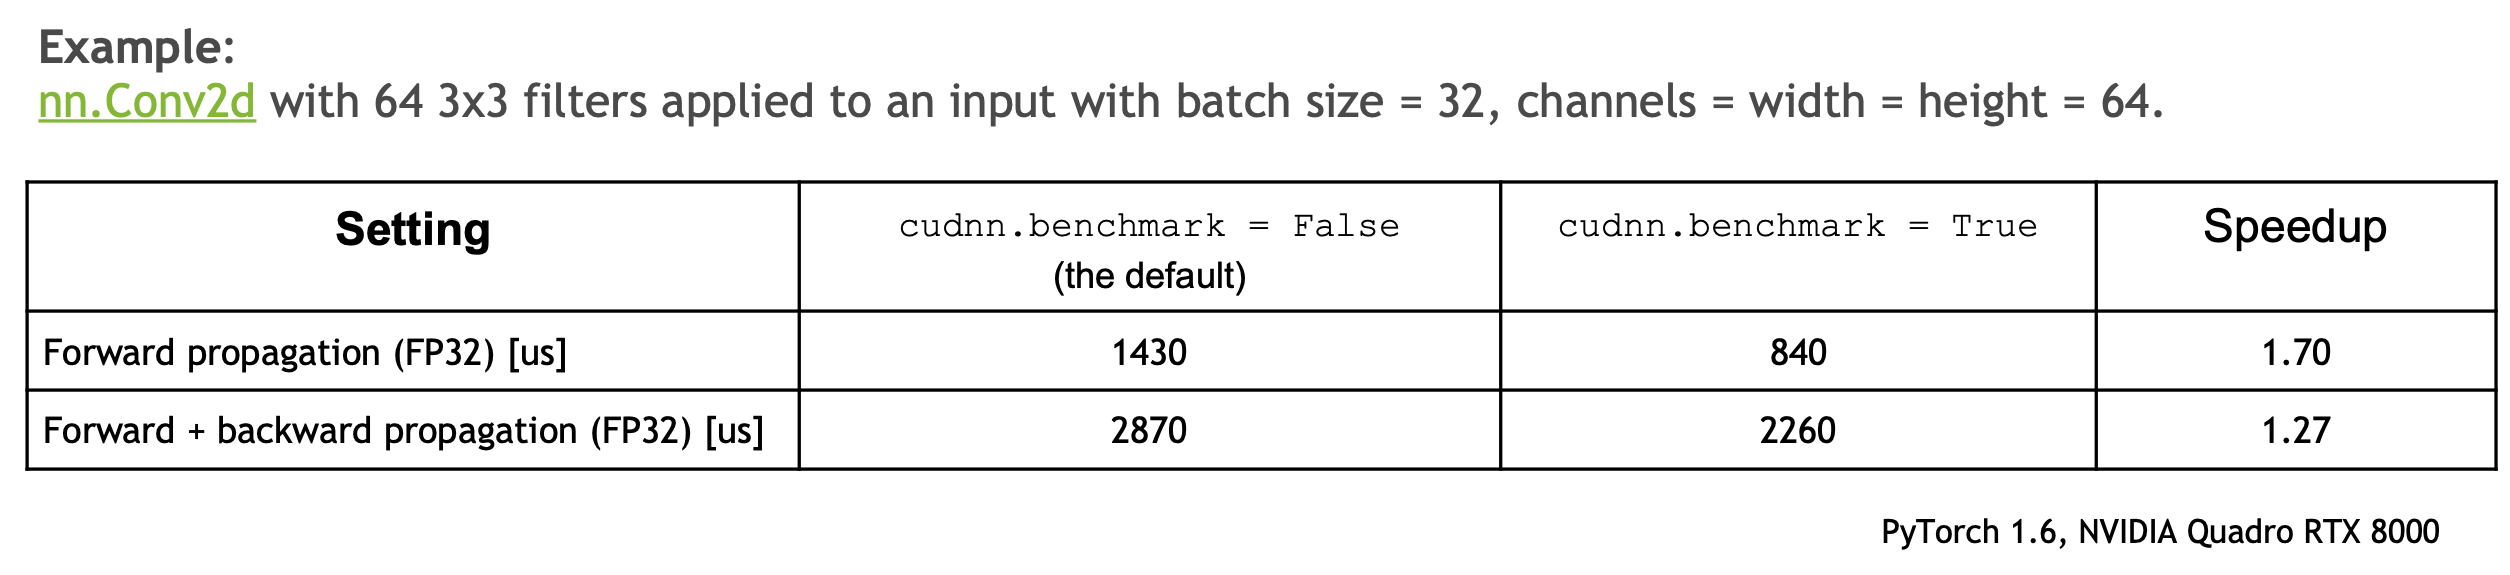

# 6.Create New Tensors on GPU

`t = tensor.rand(2,2, device=torch.device('cuda:0'))` instead of `t = tensor.rand(2,2).cuda()`. The latter will generate the tensor on CPU first and then transfer it to GPU, which takes time.

In [ ]:
start_time = time.time()

for _ in range(100):
  # Creating on the CPU, then transfering to the GPU
  cpu_tensor = torch.ones((1000, 64, 64))
  gpu_tensor = cpu_tensor.cuda()

print('Total time: {:.3f}s'.format(time.time() - start_time))

Total time: 4.784s


In [ ]:
start_time = time.time()

for _ in range(100):
  # Creating on GPU directly
  cpu_tensor = torch.ones((1000, 64, 64), device='cuda')

print('Total time: {:.3f}s'.format(time.time() - start_time))

Total time: 0.009s


# 7.Avoid Tensor Transfer between CPU and GPU


```
# bad
.cpu()
.item()
.numpy()

# good
.detach()
```



# 8.Use Gradient/Activation Checkpointing

It decreases the computation time by saving computations as functions instead of intermediate values. It also decreases memory fingerprint.

# 9.Set Gradients to None Rather Than Zero

Use 
```
for param in model.parameters():
    param.grad = None
``` or
`.zero_grad(set_to_none=True)` rather than `.zero_grad()`



recommended resource: https://github.com/prigoyal/pytorch_memonger/blob/master/tutorial/Checkpointing_for_PyTorch_models.ipynb

# 10.Use `.as_tensor()` rather than `.tensor()`

# 11.Turn off Bias Before BatchNorm

set the bias keyword to False: `torch.nn.Conv2d(..., bias=False, ...)`

# 12.Turn off Gradient Computation During Validation

set `torch.no_grad()` during validation

# 13.Use JIT to Fuse Point-wise Operations

If there is an mathematical operation on images or other tensors used in the model, use the decorator `@torch.jit.script`. By this way, calculations will be done on only one kernel, rather than multiple kernels by default.

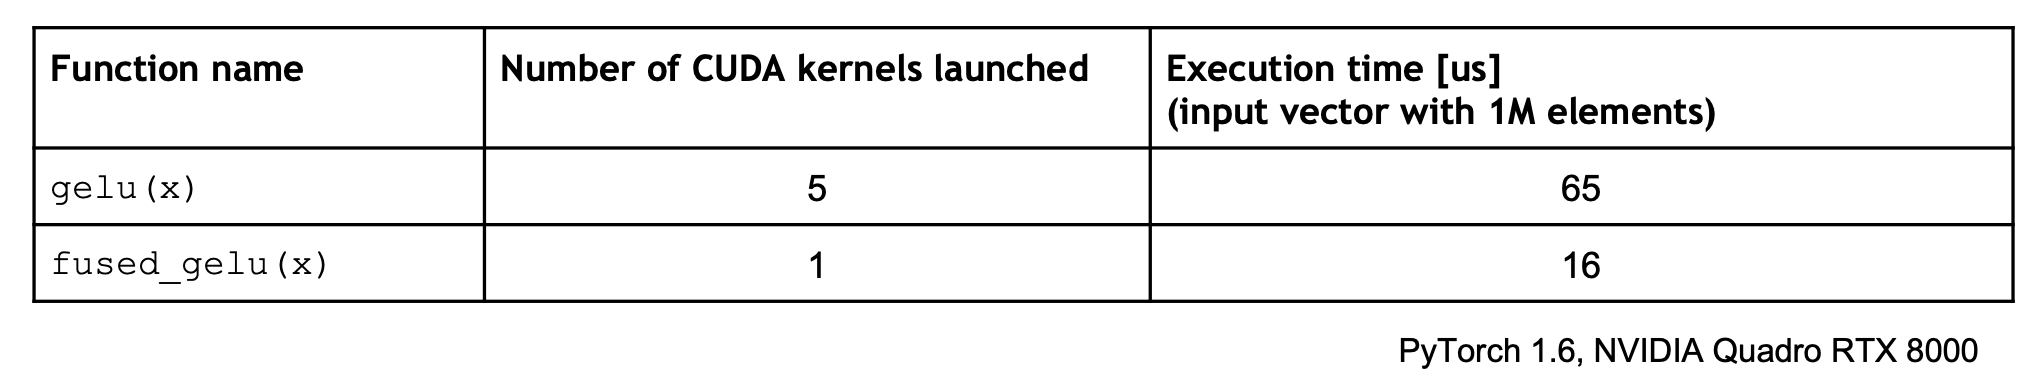

In [ ]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))

@torch.jit.script
def fused_gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))

# 14.Disable Debug APIs for Final Training

run following codes after debugging the model:
```
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
```

